#Assignment 4: Intent Classification With Neural Networks
### Submitted by: Shivani Naik

The task is to build an intent classifier with neural networks. 

Dataset: https://www.kaggle.com/datasets/hassanamin/atis-airlinetravelinformationsystem

References:
https://www.tensorflow.org/text/tutorials/classify_text_with_bert

In [ ]:
!pip install scikit-plot
!pip install tensorflow-text
!pip install contractions
#!pip install tensorflow-gpu

In [3]:
# Import Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import re
from nltk.corpus import stopwords
from wordcloud import WordCloud
from nltk.stem import  WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
import scikitplot as skplt
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM, Bidirectional, CuDNNLSTM
from keras.layers import GlobalMaxPooling1D
from tensorflow.keras.layers import Embedding
from keras.models import Sequential
from gensim.models.keyedvectors import KeyedVectors
from keras import Model
from keras.layers import Layer
import keras.backend as K
from keras.layers import Input, Dense, SimpleRNN
from keras.layers.pooling import GlobalAveragePooling1D
import logging
from numpy import array
from numpy import asarray
from numpy import zeros
#import fasttext
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import seaborn as sns
import contractions
%matplotlib inline

In [4]:
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## Data Load and EDA

In [7]:
# read train data
train_df = pd.read_csv("atis_intents_train.csv", header = None)
train_df.columns = ['intent','text']
train_df.head()

,intent,text
0,atis_flight,i want to fly from boston at 838 am and arriv...
1,atis_flight,what flights are available from pittsburgh to...
2,atis_flight_time,what is the arrival time in san francisco for...
3,atis_airfare,cheapest airfare from tacoma to orlando
4,atis_airfare,round trip fares from pittsburgh to philadelp...


In [8]:
test_df = pd.read_csv("atis_intents_test.csv", header = None)
test_df.columns = ['intent','text']
test_df.head()

,intent,text
0,atis_flight,i would like to find a flight from charlotte ...
1,atis_airfare,on april first i need a ticket from tacoma to...
2,atis_flight,on april first i need a flight going from pho...
3,atis_flight,i would like a flight traveling one way from ...
4,atis_flight,i would like a flight from orlando to salt la...


Let us check the distribution of classes. We see there is some class imbalance in the data.

In [24]:
train_df.groupby('intent').describe()

text         \
                    count unique   
intent                             
atis_abbreviation     147    108   
atis_aircraft          81     78   
atis_airfare          423    403   
atis_airline          157    148   
atis_flight          3666   3426   
atis_flight_time       54     52   
atis_ground_service   255    235   
atis_quantity          51     49   

                                                                             
                                                                   top freq  
intent                                                                       
atis_abbreviation                                  what is fare code h    8  
atis_aircraft         show me the aircraft that canadian airlines uses    2  
atis_airfare          round trip fares from baltimore to philadelph...    4  
atis_airline          show me the airlines for flights to or from l...    2  
atis_flight           show me the flights from san francisco to boston    5  
atis_flight_time      please list the flight times from pittsburgh ...    2  
atis_ground_service   what ground transportation is available in sa...    4  
atis_quantity         how many fares are there one way from tacoma ...    2

Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


In [22]:
train_df['intent'].value_counts(normalize = True)

atis_flight            0.758378
atis_airfare           0.087505
atis_ground_service    0.052751
atis_airline           0.032478
atis_abbreviation      0.030410
atis_aircraft          0.016756
atis_flight_time       0.011171
atis_quantity          0.010550
Name: intent, dtype: float64

In [25]:
test_df.groupby('intent').describe()

text         \
                    count unique   
intent                             
atis_abbreviation      33     26   
atis_aircraft           9      8   
atis_airfare           48     48   
atis_airline           38     28   
atis_flight           632    613   
atis_flight_time        1      1   
atis_ground_service    36     36   
atis_quantity           3      3   

                                                                             
                                                                   top freq  
intent                                                                       
atis_abbreviation                          what does fare code bh mean    5  
atis_aircraft                           tell me about the m80 aircraft    2  
atis_airfare          on april first i need a ticket from tacoma to...    1  
atis_airline                                       which airline is us    4  
atis_flight           what is the earliest arriving flight from hou...    2  
atis_flight_time      what are the departure times from detroit to ...    1  
atis_ground_service   does tacoma airport offer transportation from...    1  
atis_quantity         how many canadian airlines international flig...    1

In [23]:
test_df['intent'].value_counts(normalize = True)

atis_flight            0.79000
atis_airfare           0.06000
atis_airline           0.04750
atis_ground_service    0.04500
atis_abbreviation      0.04125
atis_aircraft          0.01125
atis_quantity          0.00375
atis_flight_time       0.00125
Name: intent, dtype: float64

Checking distribution of classes in the dataset.

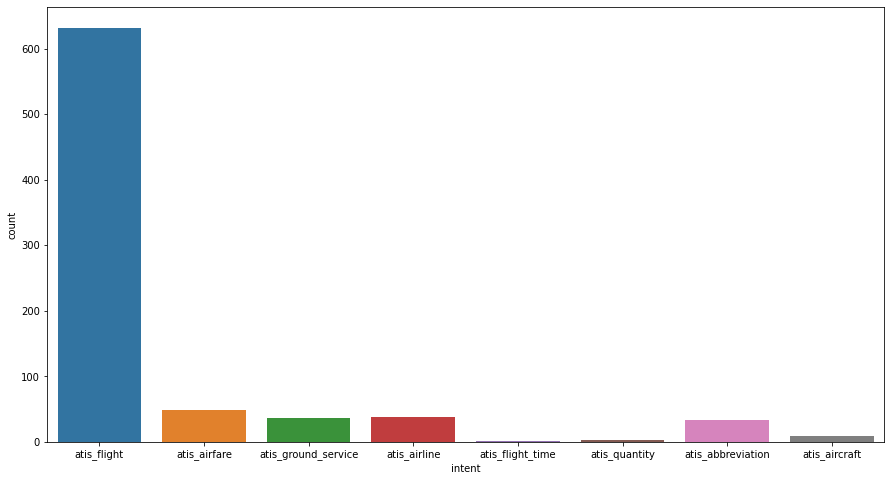

In [29]:
plt.figure(figsize = (15,8))
sns.countplot(data = train_df, x = test_df['intent'])

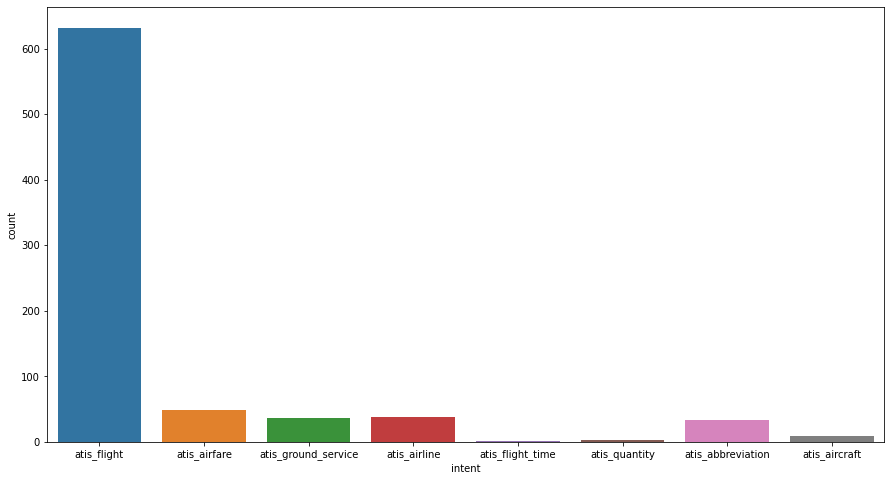

In [28]:
plt.figure(figsize = (15,8))
sns.countplot(data = test_df, x = test_df['intent'])

In [9]:
# Mount data
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Since there is no Keras wrapper for Attention layer, I have used a custom Attention class.

Reference: https://machinelearningmastery.com/adding-a-custom-attention-layer-to-recurrent-neural-network-in-keras/


In [10]:
# Custom Attention Layer
class attention(Layer):
    def __init__(self,**kwargs):
        super(attention,self).__init__(**kwargs)
 
    def build(self,input_shape):
        self.W=self.add_weight(name='attention_weight', shape=(input_shape[-1],1), 
                               initializer='random_normal', trainable=True)
        self.b=self.add_weight(name='attention_bias', shape=(input_shape[1],1), 
                               initializer='zeros', trainable=True)        
        super(attention, self).build(input_shape)
 
    def call(self,x):
        e = K.tanh(K.dot(x,self.W)+self.b)
        e = K.squeeze(e, axis=-1)   
        alpha = K.softmax(e)
        alpha = K.expand_dims(alpha, axis=-1)
        context = x * alpha
        context = K.sum(context, axis=1)
        return context

## Deep Learning Pipeline Class

I have included all the functions for preprocessing and training different neural networks in a class.

In [12]:
class DLPipeline():
  def __init__(self):
    pass

  def removeStopwords(self, sentence):
    '''Removes stopwords from a sentence'''
    stop_words = stopwords.words('english')
    tokens = [token for token in sentence.split() if token not in stop_words]
    return tokens

  def preprocess(self, text):
    '''Preprocesses text, removes punctuation and extra spaces'''
    special_characters = re.compile("[^A-Za-z0-9 ]")
    # fix contractions
    text = contractions.fix(text)
    # remove punctuation
    s = re.sub(special_characters, " ", text)
    s = re.sub(r"\s+[a-zA-Z]\s+", ' ', s)
    s = re.sub(r'\s+', ' ', s)
    # remove stopwords
    s = self.removeStopwords(s)
    return s

  def generate_wordcloud(self, text):
    word_cloud = WordCloud(collocations = False, background_color = 'white').generate(text)
    plt.figure(figsize=(15,8))
    plt.imshow(word_cloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

  def tokenize(self, X_train, X_test):
    '''Tokenize text in format required by Keras models'''
    tokenizer = Tokenizer(num_words=5000)
    tokenizer.fit_on_texts(X_train)
    # Convert text to token sequences
    X_train = tokenizer.texts_to_sequences(X_train)
    X_test = tokenizer.texts_to_sequences(X_test)
    # Vocab size plus 1 because 0 index is reserved
    vocab_size = len(tokenizer.word_index) + 1
    return (X_train, X_test, tokenizer, vocab_size)
  
  def create_padding(self, X_train, X_test, maxlen = 100):
    '''Pads input sentences to length maxlen'''
    X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
    X_test = pad_sequences(X_test, padding='post', maxlen=maxlen) 
    return (X_train, X_test)

  def load_glove_embedding_dictionary(self, root, glove_file_name = 'glove.6B.100d.txt'):
    '''Loads pretrained Glove vectors from downloaded file'''
    glove_embeddings_dict = dict()
    glove_file = open(root + glove_file_name, encoding="utf8")
    for line in glove_file:
        records = line.split()
        word = records[0]
        word_vector = asarray(records[1:], dtype='float32')
        glove_embeddings_dict[word] = word_vector
    glove_file.close()
    return glove_embeddings_dict

  def load_fasttext_embedding_dictionary(self, root, filename):
    ft = fasttext.load_model(root+filename)
    return ft

  def create_glove_embedding_matrix(self, tokenizer, embeddings_dict, vocab_size, embedding_dim = 100):
    '''Creates Embedding matrix from pretrained Glove vectors'''
    # Create an empty embedding matrix of dimensions vocab_size x embedding_dim
    # Each row corresponds to embedding of a word in the vocab
    embedding_matrix = zeros((vocab_size, embedding_dim)) 
    # retrieve pretrained Glove embedding for all words of our vocab
    for word, index in tokenizer.word_index.items():
        embedding_vector = embeddings_dict.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector
    return embedding_matrix

  def load_w2vec_embedding_dictionary(self, root, w2vec_file_name = 'GoogleNews-vectors-negative300.bin'):
    '''Loads pretrained Word2vec vectors from downloaded file'''
    w2vec_file_name = root + w2vec_file_name
    logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
    print("Loading word2vec model")
    word2vec_model = KeyedVectors.load_word2vec_format(w2vec_file_name, binary=True)
    return word2vec_model

  def create_embedding_matrix(self, tokenizer, w2vec_embeddings_dict, vocab_size, embedding_dim):
    '''Creates Embedding matrix from pretrained Word2Vec vectors'''
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    for word, i in tokenizer.word_index.items():
      if word in w2vec_embeddings_dict:
        embedding_vector = w2vec_embeddings_dict[word]
      else:
        embedding_vector = None
      if embedding_vector is not None:  
        embedding_matrix[i] = embedding_vector
    return embedding_matrix

  def plot_accuracy_loss(self, history):
    '''Creates loss and accuracy plot of training and validation from training history'''
    # Plot accuracy
    plt.figure(figsize = (15,8))
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc='upper left')
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.show()

    # Plot loss
    plt.figure(figsize = (15,8))
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc='upper left')
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.show()


  def create_BiLSTM_nn_model(self, embedding_matrix, vocab_size, maxlen, embedding_dim, dense):
    '''Creates an BiLSTM model with given parameters'''
    model = Sequential()
    # Create embedding layer, with non trainable parameters 
    embedding_layer = Embedding(input_dim = vocab_size, 
                                output_dim = embedding_dim, 
                                weights=[embedding_matrix], 
                                input_length=maxlen , 
                                trainable=False)
    model.add(embedding_layer)
    # Add a BiLSTM layer
    model.add(Bidirectional(LSTM(128)))
    # Add the final Dense layer for classification with softmax
    model.add(Dense(dense, activation = 'softmax'))
    METRICS = [
        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    # compile model with categorical cross entropy
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=METRICS)
    return model
  

  def create_BiLSTM_Attention_nn_model(self, lstm_units, embedding_matrix, vocab_size, max_len, embedding_dim, dense):
    '''Creates an BiLSTM model with Attention and given parameters'''
    x=Input(shape=(max_len,))
    # Create embedding layer, with non trainable parameters 
    embedding_layer = Embedding(input_dim = vocab_size, 
                                output_dim = embedding_dim, 
                                weights=[embedding_matrix], 
                                input_length=max_len , 
                                trainable=False)(x)
    # Add a BiLSTM layer                            
    lstm_layer = Bidirectional(LSTM(lstm_units, return_sequences=True))(embedding_layer)
    # Add an Attention layer 
    attention_layer = attention()(lstm_layer)
    # Add the final Dense layer for classification with softmax
    outputs=Dense(dense, trainable=True, activation='softmax')(attention_layer)
    model = Model(x,outputs)
    METRICS = [
        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    # compile model with categorical cross entropy
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=METRICS)
    return model   

  def create_bert_model(self,bert_preprocess, bert_encoder, dense):
    '''Creates a BERT model for classification'''
    lstm_units = 2
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    # PReprocess input according to BERT
    preprocessed_text = bert_preprocess(text_input)
    outputs = bert_encoder(preprocessed_text)
    l = outputs['pooled_output']
    # Add dropout layer to prevent overfitting
    x = tf.keras.layers.Dropout(0.1, name="dropout")(l)
    out = tf.keras.layers.Dense(dense, activation='softmax', name="output")(x)
    model = tf.keras.Model(inputs=[text_input], outputs = [out])

    METRICS = [
        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    # compile model with categorical cross entropy
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=METRICS)
    return model

  def train_evaluate_model(self, model, X_train, y_train, X_test, y_test, 
                         epochs = 10, batch_size = 128):
    '''Trains and evaluates a model'''
    history = model.fit(X_train, 
                        y_train, 
                        batch_size=batch_size, 
                        epochs=epochs, 
                        verbose=1, 
                        validation_split=0.2)
    score = model.evaluate(X_test, y_test, verbose=1)
    print("Test loss, Test Accuracy, Test Precision, Test Recall: ", score)
    return history


  def evaluate_model(self, model, X_test, y_test):
    '''Evaluates a model with different metrics'''
    y_pred = model.predict(X_test, verbose = 1, batch_size=64)
    y_pred_bool = np.argmax(y_pred, axis = 1)
    y_test = np.argmax(y_test,axis = 1)
    print(classification_report(y_test, y_pred_bool))
    skplt.metrics.plot_confusion_matrix(y_test, y_pred_bool, title="Confusion Matrix",
                  text_fontsize='large')
    plt.show()



In [13]:
# Instantiate DL Pipeline
dl_pipeline = DLPipeline()

## Wordcloud
Let us check the frequently appearing words in the dataset. We see flight, denver, atlanta, francisco, boston appear very frequently, probably because there are many passengers traveling from these cities.

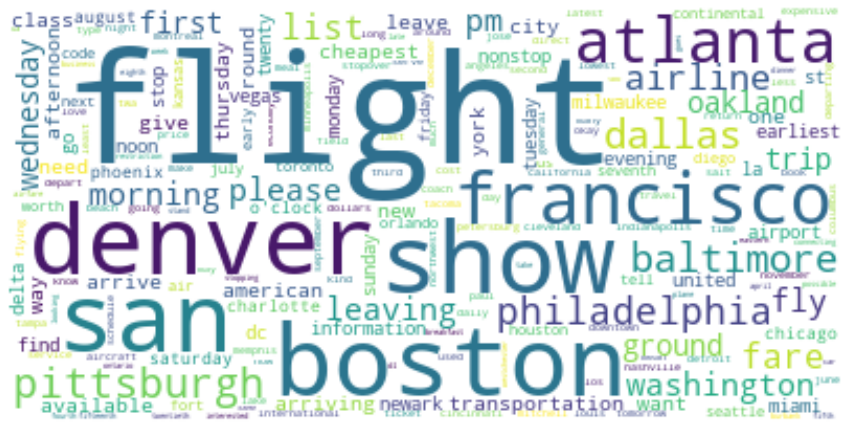

In [32]:
all_text = ' '.join(train_df['text'])
dl_pipeline.generate_wordcloud(all_text)

### Data Preprocessing
We will preprocess the data and label encode the target variable.

In [14]:
# Preprocess X
X_train = list(train_df['text'].apply(lambda x: dl_pipeline.preprocess(x)))
X_test = list(test_df['text'].apply(lambda x: dl_pipeline.preprocess(x)))

# Onehot Encode the y variable
y_train = pd.get_dummies(train_df['intent']).values
y_test = pd.get_dummies(test_df['intent']).values

In [56]:
len(X_train), y_train.shape, len(X_test), y_test.shape

(4834, (4834, 8), 800, (800, 8))

### Tokenize Data
Let us tokenize the data in the format required by Keras models.

In [15]:
X_train, X_test, tokenizer, vocab_size = dl_pipeline.tokenize(X_train, X_test)
len(X_train), len(tokenizer.word_index)

(4834, 763)

###Padding Data
We will pad the data to max_len, to make all sentences of the same length for inputting to the neural networks.

In [16]:
max_len = 100
X_train, X_test = dl_pipeline.create_padding(X_train, X_test, max_len)
X_train.shape, X_test.shape,X_test.shape

((4834, 100), (800, 100), (800, 100))

## Neural Networks with Glove Embeddings
I have trained following models with pre trained Glove Embeddings:

* BiLSTM
* BiLSTM with Attention



### Loading Glove Vectors

Let us load the pretrained Glove embeddings in a dictionary.

In [58]:
root = "/content/drive/MyDrive/"
glove_file_name = 'glove.6B.100d.txt'

glove_embeddings_dict = dl_pipeline.load_glove_embedding_dictionary(root, glove_file_name)

### Creating Embedding Matrix
We will create an embedding matrix from the GloVe vectors that will be used as weights in the embedding layer of our neural networks. The embedding dimension for Glove vectors is 100.

In [59]:
embedding_dim = 100
embedding_matrix = dl_pipeline.create_glove_embedding_matrix(tokenizer, glove_embeddings_dict, vocab_size, embedding_dim)

embedding_matrix.shape

(764, 100)

## BiLSTM
Let us create a BiLSTM model with the embeddings from Glove.

In [70]:
dense = 8
bilstm_model = dl_pipeline.create_BiLSTM_nn_model(embedding_matrix, vocab_size, max_len, embedding_dim, dense)

In [71]:
bilstm_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 100, 100)          76400     
                                                                 
 bidirectional_4 (Bidirectio  (None, 256)              234496    
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 8)                 2056      
                                                                 
Total params: 312,952
Trainable params: 236,552
Non-trainable params: 76,400
_________________________________________________________________


### Train model
I have experimented with different hyperparameters:
* epochs
*batch_size
* Number of hidden units

In [72]:
epochs = 10
batch_size = 128
history = dl_pipeline.train_evaluate_model(bilstm_model, X_train, y_train, X_test, 
                                           y_test, epochs, batch_size)

Epoch 1/10
31/31 [==============================] - 32s 887ms/step - loss: 0.9998 - accuracy: 0.9329 - precision: 0.8059 - recall: 0.6100 - val_loss: 0.6941 - val_accuracy: 0.9470 - val_precision: 0.8147 - val_recall: 0.7456
Epoch 2/10
31/31 [==============================] - 28s 904ms/step - loss: 0.5548 - accuracy: 0.9601 - precision: 0.8773 - recall: 0.7916 - val_loss: 0.3833 - val_accuracy: 0.9719 - val_precision: 0.9204 - val_recall: 0.8490
Epoch 3/10
31/31 [==============================] - 19s 626ms/step - loss: 0.3395 - accuracy: 0.9746 - precision: 0.9312 - recall: 0.8606 - val_loss: 0.2396 - val_accuracy: 0.9833 - val_precision: 0.9525 - val_recall: 0.9121
Epoch 4/10
31/31 [==============================] - 19s 623ms/step - loss: 0.2299 - accuracy: 0.9831 - precision: 0.9504 - recall: 0.9123 - val_loss: 0.1715 - val_accuracy: 0.9885 - val_precision: 0.9670 - val_recall: 0.9400
Epoch 5/10
31/31 [==============================] - 19s 619ms/step - loss: 0.1675 - accuracy: 0.9889

### Evaluate Model
Evaluate model with different metrics:
* Accuracy
* Precision
* Recall
* F1-score


13/13 [==============================] - 7s 311ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        33
           1       1.00      1.00      1.00         9
           2       1.00      0.94      0.97        48
           3       1.00      0.92      0.96        38
           4       0.99      0.99      0.99       632
           5       1.00      1.00      1.00         1
           6       1.00      1.00      1.00        36
           7       0.43      1.00      0.60         3

    accuracy                           0.99       800
   macro avg       0.93      0.98      0.94       800
weighted avg       0.99      0.99      0.99       800



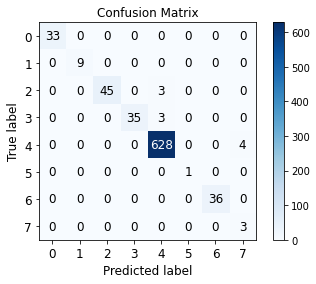

In [73]:
dl_pipeline.evaluate_model(bilstm_model, X_test, y_test)

### Plot Accuracy and Loss


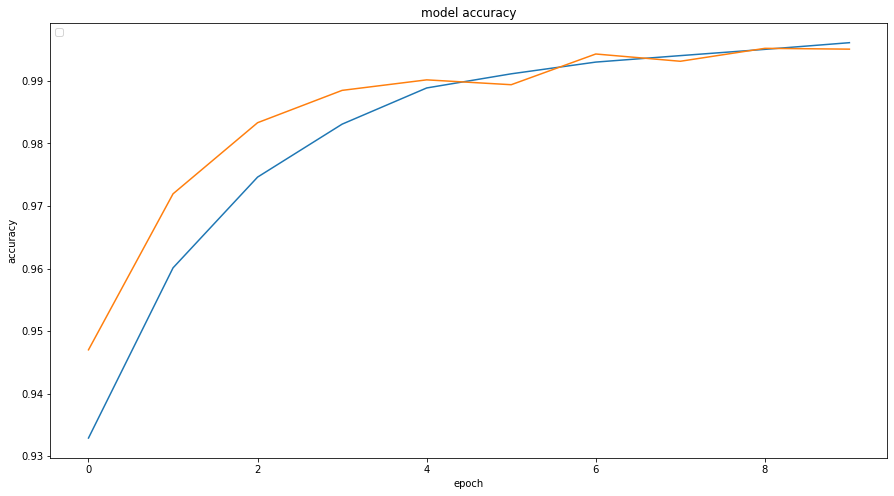

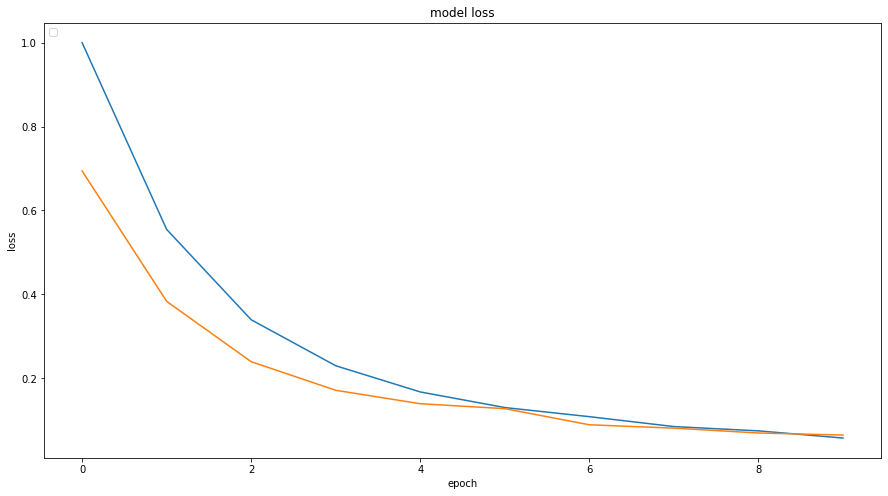

In [74]:
dl_pipeline.plot_accuracy_loss(history)

## BiLSTM with Attention
Let us create a BiLSTM model with Attention layer and the embeddings from Glove.

In [75]:
lstm_units = 128
dense = 8
bilstm_attention_model = dl_pipeline.create_BiLSTM_Attention_nn_model(lstm_units, embedding_matrix, vocab_size, max_len, embedding_dim, dense)

In [76]:
bilstm_attention_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 100)]             0         
                                                                 
 embedding_5 (Embedding)     (None, 100, 100)          76400     
                                                                 
 bidirectional_5 (Bidirectio  (None, 100, 256)         234496    
 nal)                                                            
                                                                 
 attention_2 (attention)     (None, 256)               356       
                                                                 
 dense_5 (Dense)             (None, 8)                 2056      
                                                                 
Total params: 313,308
Trainable params: 236,908
Non-trainable params: 76,400
________________________________________________

### Train model
I have experimented with different hyperparameters:
* epochs
*batch_size
* Number of hidden units

In [77]:
epochs = 20
batch_size = 128
history = dl_pipeline.train_evaluate_model(bilstm_attention_model, X_train, y_train, X_test, 
                                           y_test, epochs, batch_size)

Epoch 1/20
31/31 [==============================] - 26s 695ms/step - loss: 1.2477 - accuracy: 0.9188 - precision: 0.7507 - recall: 0.5250 - val_loss: 0.9030 - val_accuracy: 0.9374 - val_precision: 0.7497 - val_recall: 0.7497
Epoch 2/20
31/31 [==============================] - 20s 653ms/step - loss: 0.8210 - accuracy: 0.9445 - precision: 0.7895 - recall: 0.7585 - val_loss: 0.6943 - val_accuracy: 0.9489 - val_precision: 0.8349 - val_recall: 0.7373
Epoch 3/20
31/31 [==============================] - 20s 654ms/step - loss: 0.5880 - accuracy: 0.9588 - precision: 0.8855 - recall: 0.7701 - val_loss: 0.4694 - val_accuracy: 0.9696 - val_precision: 0.9656 - val_recall: 0.7849
Epoch 4/20
31/31 [==============================] - 22s 717ms/step - loss: 0.3695 - accuracy: 0.9750 - precision: 0.9466 - recall: 0.8482 - val_loss: 0.2439 - val_accuracy: 0.9841 - val_precision: 0.9597 - val_recall: 0.9111
Epoch 5/20
31/31 [==============================] - 20s 661ms/step - loss: 0.2506 - accuracy: 0.9843

### Evaluate Model
Evaluate model with different metrics:
* Accuracy
* Precision
* Recall
* F1-score


13/13 [==============================] - 5s 266ms/step
              precision    recall  f1-score   support

           0       0.97      1.00      0.99        33
           1       1.00      0.89      0.94         9
           2       0.98      0.98      0.98        48
           3       1.00      1.00      1.00        38
           4       1.00      0.99      1.00       632
           5       1.00      1.00      1.00         1
           6       1.00      0.97      0.99        36
           7       0.43      1.00      0.60         3

    accuracy                           0.99       800
   macro avg       0.92      0.98      0.94       800
weighted avg       0.99      0.99      0.99       800



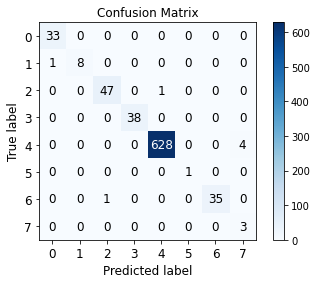

In [78]:
dl_pipeline.evaluate_model(bilstm_attention_model, X_test, y_test)

### Plot Accuracy and Loss


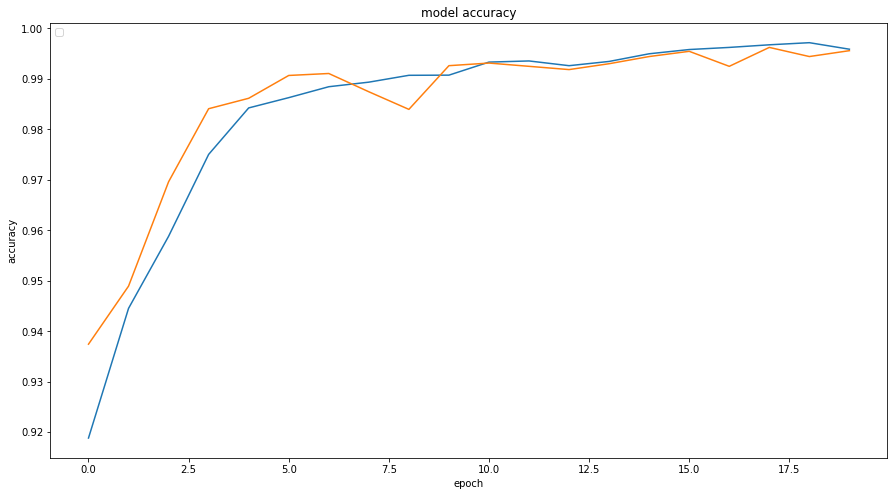

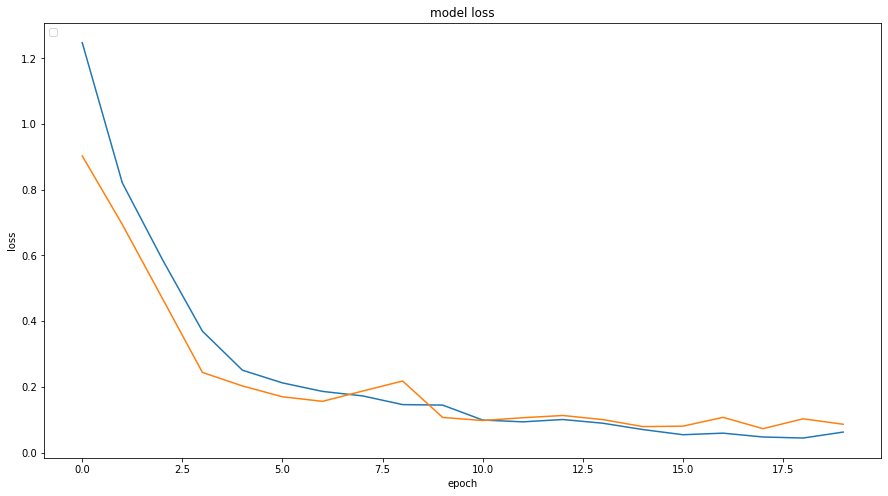

In [79]:
dl_pipeline.plot_accuracy_loss(history)

## Neural Networks with Word2Vec

### Loading Word2Vec Vectors

Let us load the pretrained Word2Vec embeddings in a dictionary.

In [17]:
root = "/content/drive/MyDrive/"
w2vec_file_name = 'GoogleNews-vectors-negative300.bin'

w2vec_embedding_dict = dl_pipeline.load_w2vec_embedding_dictionary(root, w2vec_file_name)

2022-07-09 20:10:52,177 : INFO : loading projection weights from /content/drive/MyDrive/GoogleNews-vectors-negative300.bin


Loading word2vec model


2022-07-09 20:11:56,569 : INFO : loaded (3000000, 300) matrix from /content/drive/MyDrive/GoogleNews-vectors-negative300.bin


### Creating Embedding Matrix
We will create an embedding matrix from the Word2Vec vectors that will be used as weights in the embedding layer of our neural networks.

In [18]:
embedding_dim = 300
embedding_matrix = dl_pipeline.create_embedding_matrix(tokenizer, w2vec_embedding_dict, vocab_size, embedding_dim)

### BiLSTM
Let us create an BiLSTM model with the embeddings from Fasttext.

In [82]:
embedding_dim = 300
lstm_units = 128
dense = 8
w2vec_bilstm_model = dl_pipeline.create_BiLSTM_nn_model(embedding_matrix, vocab_size, max_len, embedding_dim, dense)

In [83]:
w2vec_bilstm_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 100, 300)          229200    
                                                                 
 bidirectional_6 (Bidirectio  (None, 256)              439296    
 nal)                                                            
                                                                 
 dense_6 (Dense)             (None, 8)                 2056      
                                                                 
Total params: 670,552
Trainable params: 441,352
Non-trainable params: 229,200
_________________________________________________________________


In [ ]:
epochs = 20
batch_size = 128
history = dl_pipeline.train_evaluate_model(w2vec_bilstm_model, X_train, y_train, X_test, 
                                           y_test, epochs, batch_size)

Epoch 1/20
31/31 [==============================] - 34s 914ms/step - loss: 1.0152 - accuracy: 0.9310 - precision: 0.8196 - recall: 0.5743 - val_loss: 0.6508 - val_accuracy: 0.9484 - val_precision: 0.8287 - val_recall: 0.7404
Epoch 2/20
31/31 [==============================] - 32s 1s/step - loss: 0.5153 - accuracy: 0.9646 - precision: 0.9060 - recall: 0.8001 - val_loss: 0.3357 - val_accuracy: 0.9761 - val_precision: 0.9463 - val_recall: 0.8573
Epoch 3/20
31/31 [==============================] - 30s 977ms/step - loss: 0.3086 - accuracy: 0.9785 - precision: 0.9464 - recall: 0.8774 - val_loss: 0.2085 - val_accuracy: 0.9851 - val_precision: 0.9692 - val_recall: 0.9100
Epoch 4/20
31/31 [==============================] - 29s 951ms/step - loss: 0.2083 - accuracy: 0.9845 - precision: 0.9603 - recall: 0.9141 - val_loss: 0.1475 - val_accuracy: 0.9886 - val_precision: 0.9661 - val_recall: 0.9421
Epoch 5/20
31/31 [==============================] - 28s 906ms/step - loss: 0.1449 - accuracy: 0.9895 - 

### Evaluate Model
Evaluate model with different metrics:
* Accuracy
* Precision
* Recall
* F1-score


13/13 [==============================] - 8s 390ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        33
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00        48
           3       1.00      0.95      0.97        38
           4       1.00      0.99      1.00       632
           5       1.00      1.00      1.00         1
           6       1.00      1.00      1.00        36
           7       0.43      1.00      0.60         3

    accuracy                           0.99       800
   macro avg       0.93      0.99      0.95       800
weighted avg       1.00      0.99      0.99       800



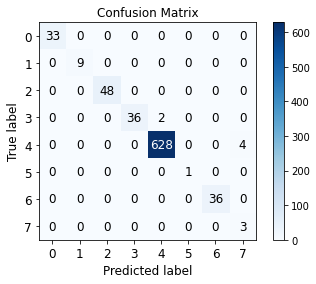

In [85]:
dl_pipeline.evaluate_model(w2vec_bilstm_model, X_test, y_test)

### Plot Accuracy and Loss

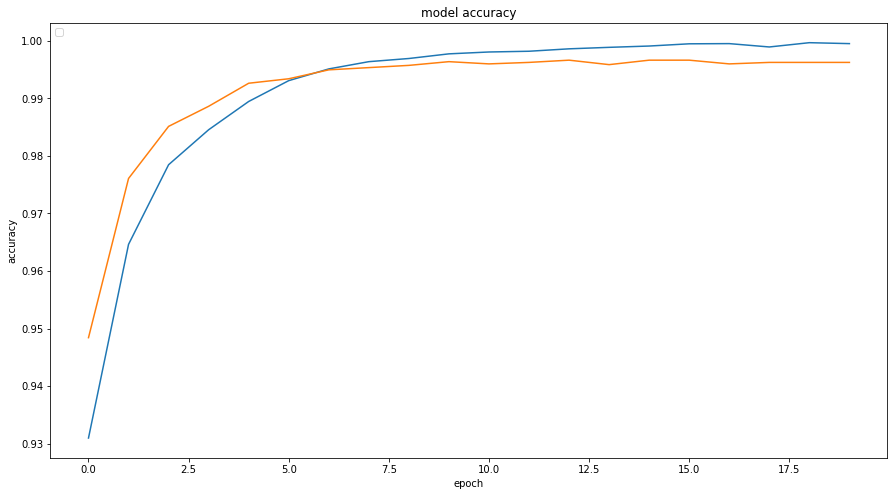

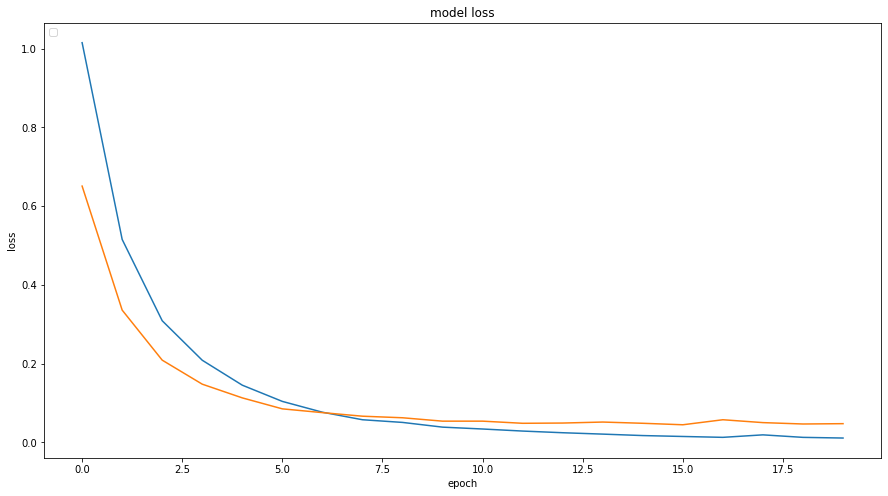

In [86]:
dl_pipeline.plot_accuracy_loss(history)

## BiLSTM with Attention
Let us create a BiLSTM model with Attention layer and the embeddings from Fasttext.

In [19]:
lstm_units = 128
dense = 8
w2vec_bilstm_attention_model = dl_pipeline.create_BiLSTM_Attention_nn_model(lstm_units, embedding_matrix, vocab_size, max_len, embedding_dim,dense)

In [20]:
w2vec_bilstm_attention_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 embedding (Embedding)       (None, 100, 300)          229200    
                                                                 
 bidirectional (Bidirectiona  (None, 100, 256)         439296    
 l)                                                              
                                                                 
 attention (attention)       (None, 256)               356       
                                                                 
 dense (Dense)               (None, 8)                 2056      
                                                                 
Total params: 670,908
Trainable params: 441,708
Non-trainable params: 229,200
_________________________________________________

### Train model
I have experimented with different hyperparameters:
* epochs
*batch_size
* Number of hidden units

In [ ]:
epochs = 20
batch_size = 128
history = dl_pipeline.train_evaluate_model(w2vec_bilstm_attention_model, X_train, y_train, X_test, 
                                           y_test, epochs, batch_size)

### Evaluate Model
Evaluate model with different metrics:
* Accuracy
* Precision
* Recall
* F1-score
*AUC ROC Score

13/13 [==============================] - 4s 294ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        33
           1       0.80      0.89      0.84         9
           2       1.00      0.98      0.99        48
           3       0.95      0.97      0.96        38
           4       0.99      1.00      1.00       632
           5       0.00      0.00      0.00         1
           6       1.00      1.00      1.00        36
           7       0.00      0.00      0.00         3

    accuracy                           0.99       800
   macro avg       0.72      0.73      0.72       800
weighted avg       0.99      0.99      0.99       800



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


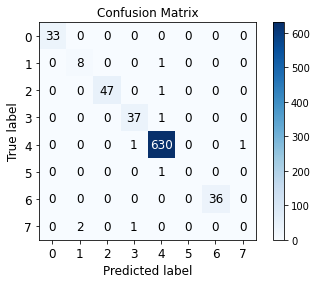

In [92]:
dl_pipeline.evaluate_model(w2vec_bilstm_attention_model, X_test, y_test)

### Plot Accuracy and Loss


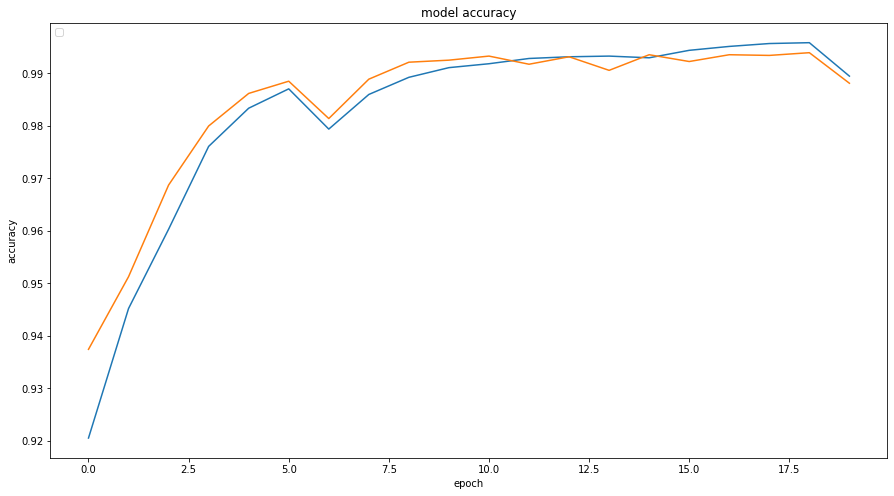

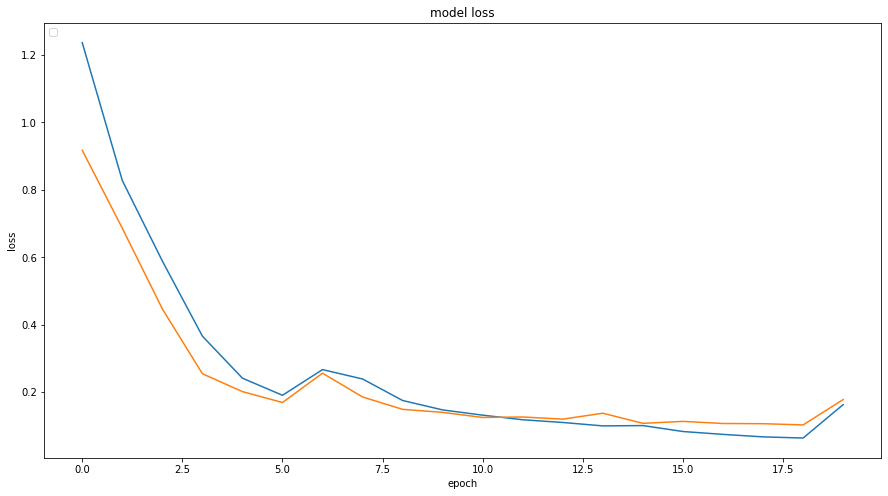

In [94]:
dl_pipeline.plot_accuracy_loss(history)

## BERT Model
Let us create a model with pretrained BERT embeddings. I will use the model provided by Tensorflow with KerasLayer wrapper. Let us define the preprocess and embedding layers.

In [22]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

2022-07-09 20:21:14,318 : INFO : Using /tmp/tfhub_modules to cache modules.
2022-07-09 20:21:14,327 : INFO : Downloading TF-Hub Module 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'.
2022-07-09 20:21:15,642 : INFO : Downloaded https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3, Total size: 1.96MB
2022-07-09 20:21:15,648 : INFO : Downloaded TF-Hub Module 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'.
2022-07-09 20:21:19,093 : INFO : Downloading TF-Hub Module 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4'.
2022-07-09 20:21:35,954 : INFO : Downloaded https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4, Total size: 429.66MB
2022-07-09 20:21:35,957 : INFO : Downloaded TF-Hub Module 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4'.


In [23]:
dense = 8
bert_model = dl_pipeline.create_bert_model(bert_preprocess, bert_encoder, dense)

In [24]:
bert_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128)}                                                

In [25]:
# X train and test for BERT model
X_train = np.array(train_df['text'])
X_test = np.array(test_df['text'])

### Train model
I have experimented with different hyperparameters:
* epochs
* batch_size
* Number of hidden units

In [26]:
epochs = 20
batch_size = 8
history = dl_pipeline.train_evaluate_model(bert_model, X_train, y_train, X_test, 
                                           y_test, epochs, batch_size)

Epoch 1/20
484/484 [==============================] - 63s 108ms/step - loss: 0.8799 - accuracy: 0.9427 - precision: 0.7942 - recall: 0.7305 - val_loss: 0.8141 - val_accuracy: 0.9462 - val_precision: 0.8356 - val_recall: 0.7094
Epoch 2/20
484/484 [==============================] - 51s 105ms/step - loss: 0.7216 - accuracy: 0.9501 - precision: 0.8343 - recall: 0.7499 - val_loss: 0.7751 - val_accuracy: 0.9501 - val_precision: 0.8827 - val_recall: 0.6929
Epoch 3/20
484/484 [==============================] - 50s 104ms/step - loss: 0.6520 - accuracy: 0.9543 - precision: 0.8546 - recall: 0.7647 - val_loss: 0.5797 - val_accuracy: 0.9558 - val_precision: 0.8507 - val_recall: 0.7839
Epoch 4/20
484/484 [==============================] - 51s 105ms/step - loss: 0.6087 - accuracy: 0.9569 - precision: 0.8620 - recall: 0.7799 - val_loss: 0.5333 - val_accuracy: 0.9582 - val_precision: 0.8570 - val_recall: 0.7994
Epoch 5/20
484/484 [==============================] - 50s 104ms/step - loss: 0.5625 - accura

### Evaluate Model
Evaluate model with different metrics:
* Accuracy
* Precision
* Recall
* F1-score

13/13 [==============================] - 9s 689ms/step


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.85      1.00      0.92        33
           1       1.00      0.11      0.20         9
           2       0.90      0.75      0.82        48
           3       0.94      0.45      0.61        38
           4       0.93      0.99      0.96       632
           5       0.00      0.00      0.00         1
           6       1.00      0.78      0.88        36
           7       0.00      0.00      0.00         3

    accuracy                           0.93       800
   macro avg       0.70      0.51      0.55       800
weighted avg       0.93      0.93      0.92       800



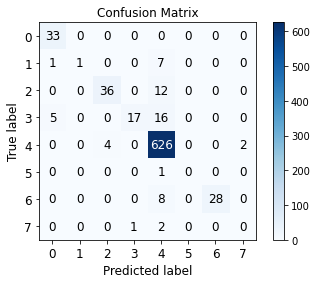

In [27]:
dl_pipeline.evaluate_model(bert_model, X_test, y_test)

### Plot Accuracy and Loss


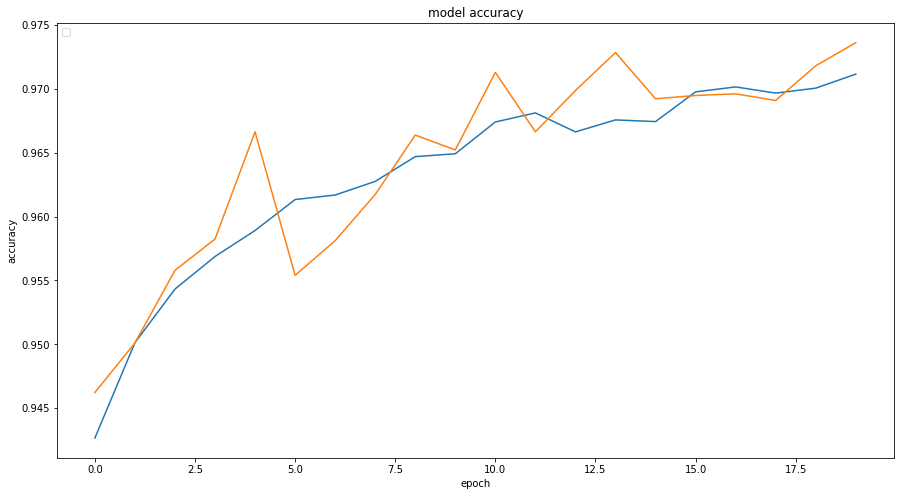

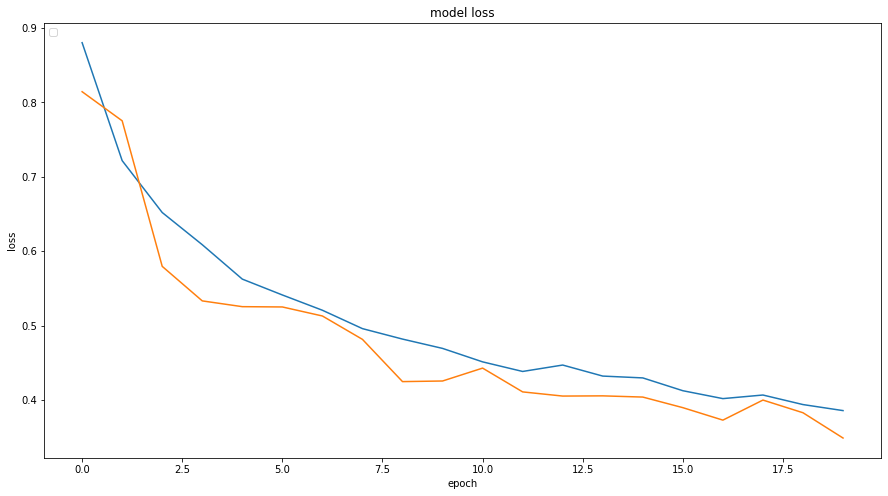

In [28]:
dl_pipeline.plot_accuracy_loss(history)

## Model Performance Comparison
These are the model performance metrics for different models with different embedding vectors. As the classification problem is imbalanced, we should also look at metrics like Precision, Recall etc, apart from accuracy.

|                                  | Accuracy | Weighted Avg Precision | Weighted Avg Recall | Weighted Avg  F1-Score |
|----------------------------------|----------|------------------------|---------------------|------------------------|
| BiLSTM (Glove)                   | 0.99     | 0.99                   | 0.99                | 0.99                   |
| BiLSTM with Attention (Glove)    | 0.99     | 0.99                   | 0.99                | 0.99                   |
| BiLSTM (Word2Vec)                | 0.99     | 1.0                   | 0.99                | 0.99                   |
| BiLSTM with Attention (Word2Vec) | 0.99     | 0.99                   | 0.99                | 0.99                   |
| BERT                             | 0.93      | 0.93                   | 0.93                 | 0.92                   |
* All models perform almost similarly across different metrics
* BiLSTM with Word2Vec has the best performance, 1.0 weighted average precision
* It correctly classifies majority of instances from classes with low support as well
* BERT is computationally expensive, and requires a GPU for faster processing. It also has a lower performance 


**Improving model performance with data:**

Model performance can be improved by increasing the amount of data. Deep learning models are known to perform better with a large amount of data, and it will also prevent
 overfitting.

The dataset has class imbalance, with 3 classes having 1% data. To improve performance, it will be beneficial to collect more data from these classes and create a balanced distribution across classes.

Model performance also depends on quality of the data, so it is important to collect data that is as diverse and varied as possible.

Data augmentation techniques to increase data can also be used. Some data augmentation techniques include 
* Back Translation - Translating to another language and back, which gives a newer sentence with similar context.
* Random word insertion - Replace random words with synonyms.
* Random Deletion - Randomly delete some word from sentence.

These techniques can be used if it is difficult to obtain more data, the augmented data will be new for the model, but easier to generate and will help in generalisation.